In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data')):
    subfolder_path = os.path.join('/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data', subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


image         label
0     /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...  without_mask
1     /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...  without_mask
2     /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...  without_mask
3     /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...  without_mask
4     /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...  without_mask
...                                                 ...           ...
7548  /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...     with_mask
7549  /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...     with_mask
7550  /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...     with_mask
7551  /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...     with_mask
7552  /drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/wit...     with_mask

[7553 rows x 2 columns]

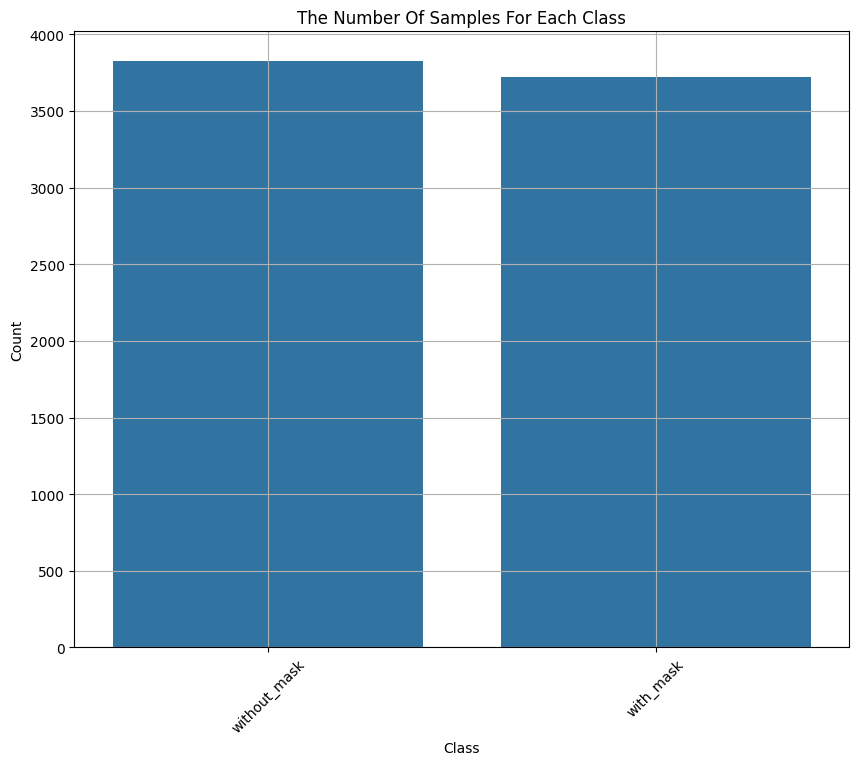

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df.label)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('The Number Of Samples For Each Class')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

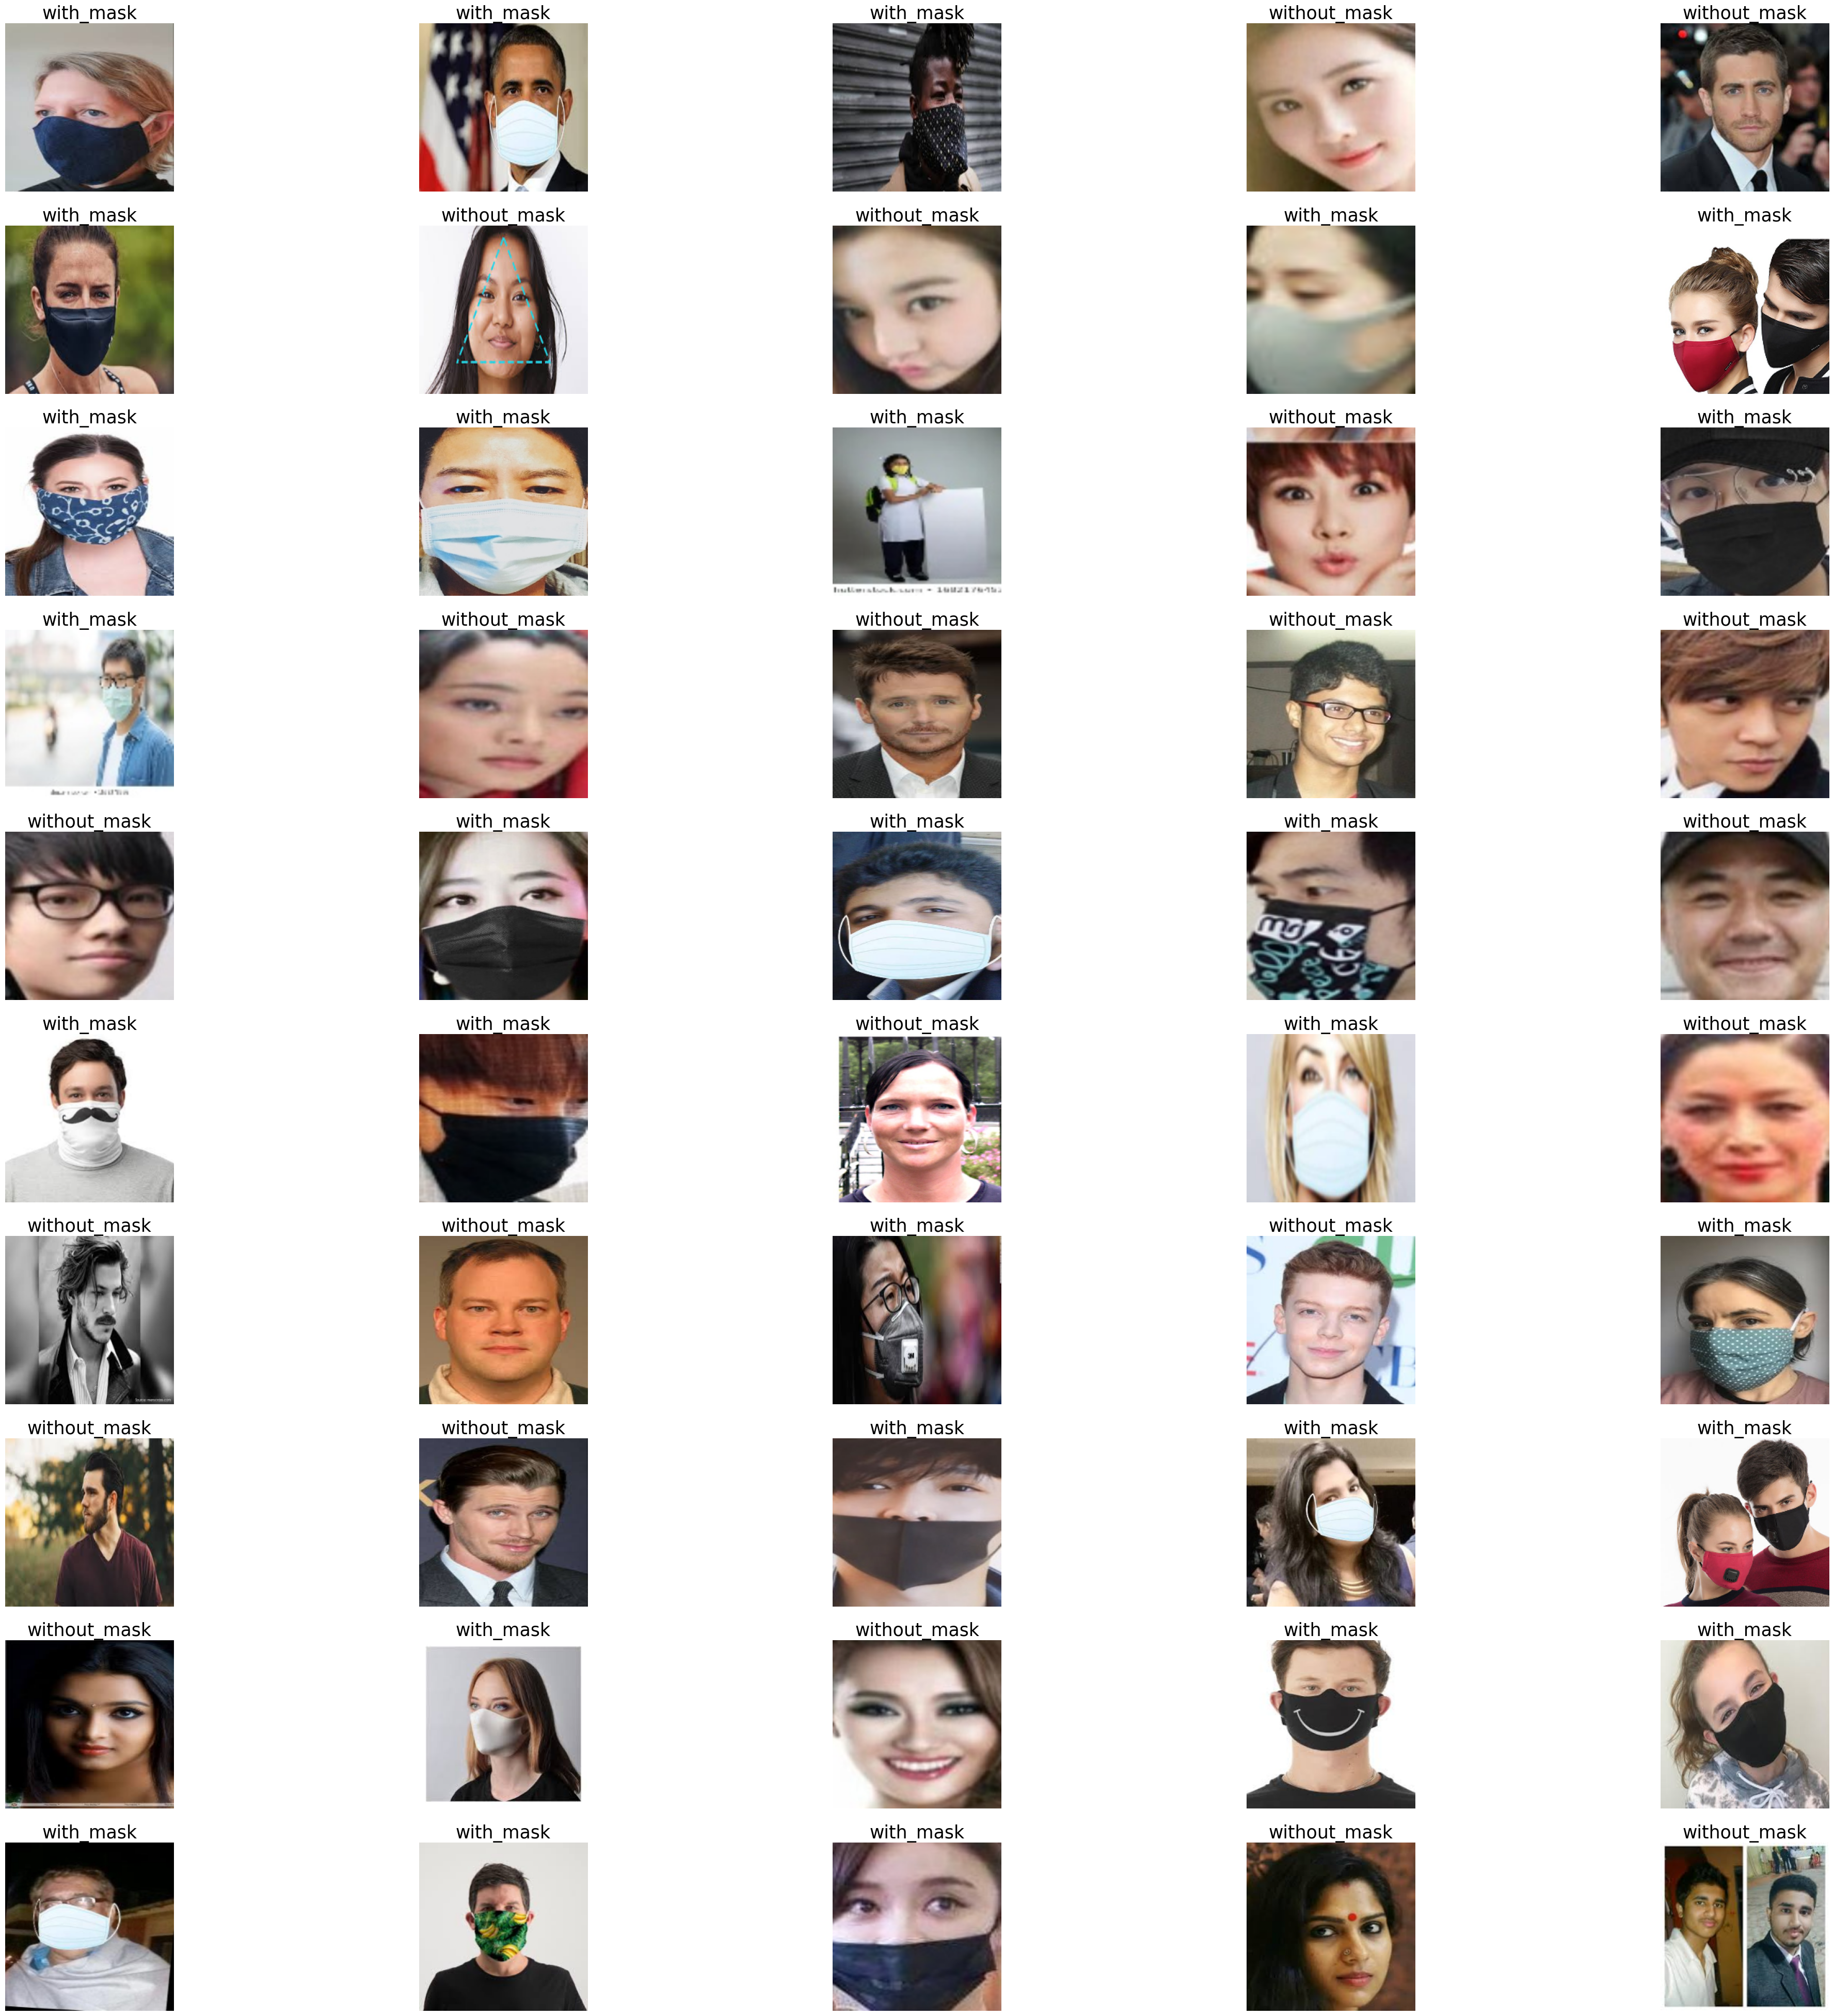

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [ ]:
image_size = (128,128)
batch_size = 20
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(2,activation=tf.nn.softmax))
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7501634 (28.62 MB)
Trainable params: 5243650 

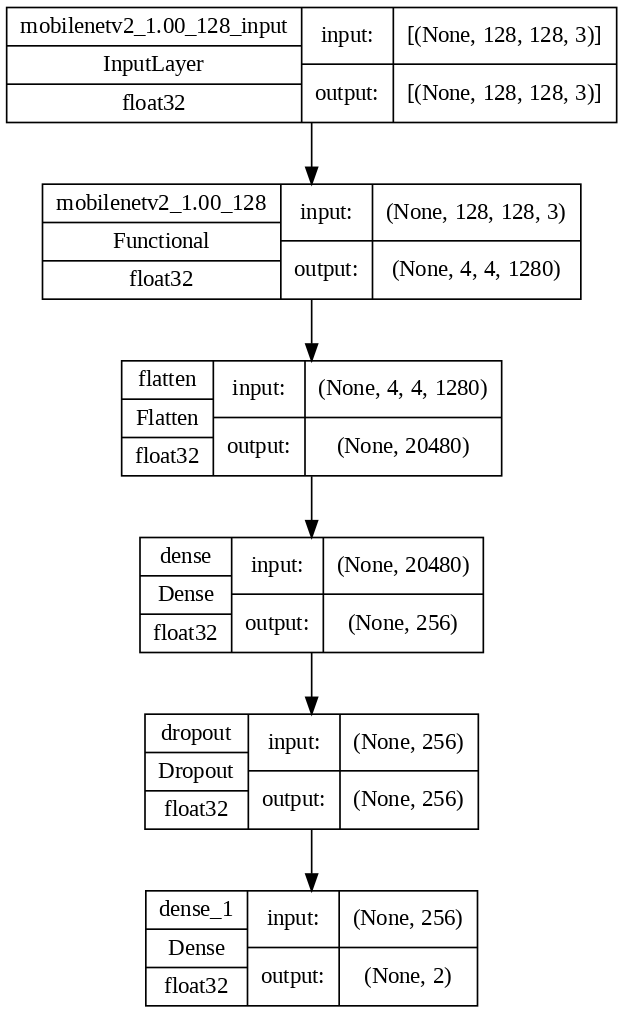

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("face_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
161/265 [=================>............] - ETA: 8:03 - loss: 0.3936 - accuracy: 0.9626

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


265/265 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.9686

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


265/265 [==============================] - 1499s 6s/step - loss: 0.2892 - accuracy: 0.9686 - val_loss: 0.0383 - val_accuracy: 0.9850
Epoch 2/10
265/265 [==============================] - 114s 430ms/step - loss: 0.0359 - accuracy: 0.9917 - val_loss: 0.0334 - val_accuracy: 0.9859
Epoch 3/10
265/265 [==============================] - 114s 429ms/step - loss: 0.0352 - accuracy: 0.9928 - val_loss: 0.0554 - val_accuracy: 0.9823
Epoch 4/10
265/265 [==============================] - 109s 410ms/step - loss: 0.0498 - accuracy: 0.9902 - val_loss: 0.0663 - val_accuracy: 0.9832
Epoch 5/10
265/265 [==============================] - 108s 408ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 0.0811 - val_accuracy: 0.9859
Epoch 6/10
265/265 [==============================] - 109s 411ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0677 - val_accuracy: 0.9876
Epoch 7/10
265/265 [==============================] - 109s 411ms/step - loss: 0.0225 - accuracy: 0.9974 - val_loss: 0.1610 - val_accuracy

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.289219  0.968602  0.038265      0.984996
1  0.035912  0.991678  0.033355      0.985878
2  0.035214  0.992813  0.055397      0.982348
3  0.049775  0.990165  0.066320      0.983230
4  0.023026  0.993758  0.081145      0.985878
5  0.008168  0.997352  0.067662      0.987643
6  0.022546  0.997352  0.161044      0.979700

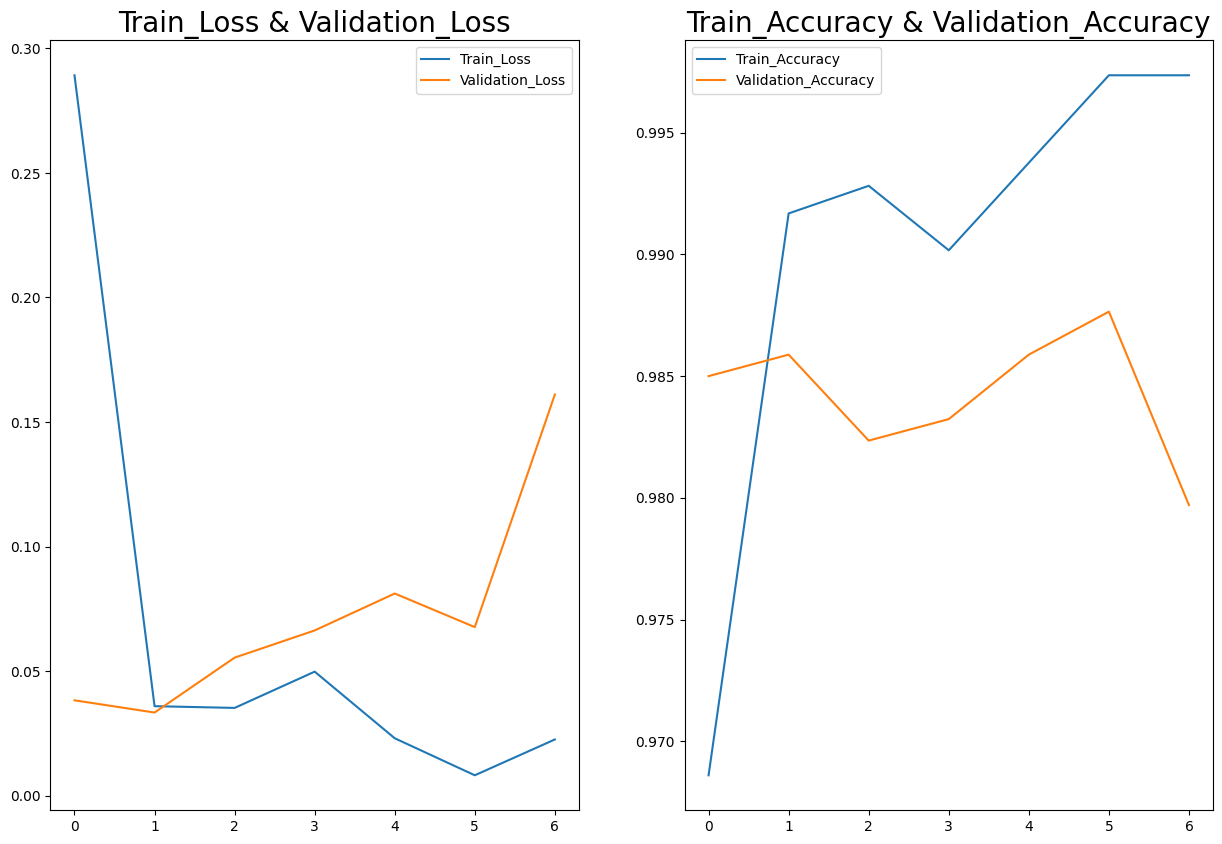

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

57/57 [==============================] - 269s 5s/step - loss: 0.0286 - accuracy: 0.9868
Test Loss = 0.028593162074685097
Test Accuracy = 0.9867607951164246


In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

57/57 [==============================] - 17s 276ms/step


Actual  Prediction
0          0           0
1          0           0
2          0           0
3          0           0
4          1           1
...      ...         ...
1128       0           0
1129       1           1
1130       0           0
1131       1           1
1132       0           0

[1133 rows x 2 columns]

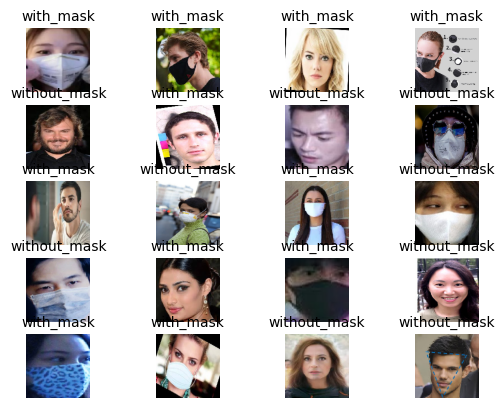

In [ ]:
import matplotlib.pyplot as plt

# Assuming images and y_test are your arrays
for n in range(min(20, len(images))):
    plt.subplot(5, 4, n+1)  # Adjust subplot layout if needed
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])], fontsize=10)  # Assuming class_names is defined
plt.show()


array([[558,   1],
       [ 14, 560]])

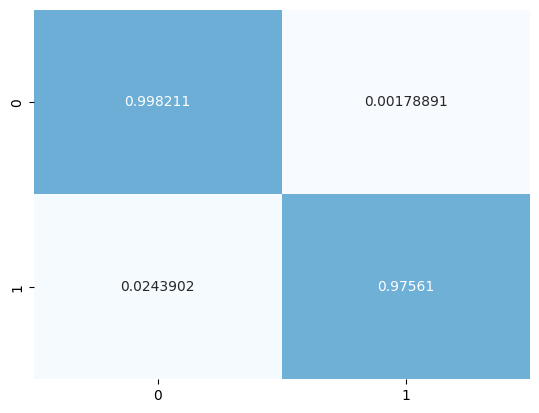

In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      1.00      0.99       559
           1       1.00      0.98      0.99       574

    accuracy                           0.99      1133
   macro avg       0.99      0.99      0.99      1133
weighted avg       0.99      0.99      0.99      1133

